#### 1. Proportion of revenue levels per tag
#### 2. Mean, standard deviation, median dollar value per tag
#### 3. Transaction frequency per tag

To do:
1. Number of unique merchants/consumers per tag - Andrew
2. Age distribution by tag (add visualization) - Andrew
3. Consumer income distribution by tag (add visualization) - Andrew
4. Take rate * Dollar_Value - Andrew
5. Unique SA2 per merchant - Patrick
6. Analyze buying power (transaction frequency and monetary value) of SA2, possibly ranking weights to merchants by SA2 - Patrick
6.1 Add SA2 (Income, Age and Buying Power) Geospatial Visualization - Nadya
7. Finalize features to use -> find correlation between features

### Analysis by Tag

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 21:53:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/07 21:53:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/07 21:53:22 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/07 21:53:22 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/07 21:53:22 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
# load BNPL dataset
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [4]:
# load all transactions datasets
paths=['../data/tables/transactions_20210228_20210827_snapshot',
       '../data/tables/transactions_20210828_20220227_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added transactions_20210228_20210827_snapshot


added transactions_20210828_20220227_snapshot


In [5]:
age = gpd.read_file("../data/abs/sa2_age.gml")
income = gpd.read_file("../data/abs/sa2_income.gml")

In [6]:
# load poa_to_sa2 dataset
poa_to_sa2 = spark.read.csv("../data/curated/poa_w_sa2.csv", header=True)

In [7]:
consumer.show(1, vertical=True)

-RECORD 0---------------------------
 name        | Yolanda Williams     
 address     | 413 Haney Gardens... 
 state       | WA                   
 postcode    | 6935                 
 gender      | Female               
 consumer_id | 1195503              
only showing top 1 row



In [8]:
details.show(1, vertical=True)

-RECORD 0--------------
 user_id     | 1       
 consumer_id | 1195503 
only showing top 1 row



In [9]:
transactions.agg({'order_datetime': 'max'}).show()
transactions.agg({'order_datetime': 'min'}).show()

+-------------------+
|max(order_datetime)|
+-------------------+
|         2022-02-27|
+-------------------+



+-------------------+
|min(order_datetime)|
+-------------------+
|         2021-02-28|
+-------------------+



In [10]:
merchants.show(1, vertical=True)

-RECORD 0----------------------------
 name         | Felis Limited        
 tags         | ((furniture, home... 
 merchant_abn | 10023283211          
only showing top 1 row



In [11]:
transactions.show(1, vertical=True)

-RECORD 0------------------------------
 user_id        | 18478                
 merchant_abn   | 62191208634          
 dollar_value   | 63.255848959735246   
 order_id       | 949a63c8-29f7-4ab... 
 order_datetime | 2021-08-20           
only showing top 1 row



In [12]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

---
### Merge transaction with consumer and merchant details

In [13]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [14]:
df_trx.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 merchant_name  | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [15]:
df_trx.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)



In [16]:
poa_to_sa2.show(5, vertical=True)

-RECORD 0---------------------------------
 poa_code_2016     | 800                  
 poa_name_2016     | 0800                 
 sa2_maincode_2016 | 701011002.0          
 sa2_name_2016     | Darwin City          
 geometry          | POLYGON ((130.834... 
-RECORD 1---------------------------------
 poa_code_2016     | 810                  
 poa_name_2016     | 0810                 
 sa2_maincode_2016 | 701021013.0          
 sa2_name_2016     | Brinkin - Nakara     
 geometry          | POLYGON ((130.863... 
-RECORD 2---------------------------------
 poa_code_2016     | 812                  
 poa_name_2016     | 0812                 
 sa2_maincode_2016 | 701021014.0          
 sa2_name_2016     | Buffalo Creek        
 geometry          | POLYGON ((130.901... 
-RECORD 3---------------------------------
 poa_code_2016     | 815                  
 poa_name_2016     | 0815                 
 sa2_maincode_2016 | 701021013.0          
 sa2_name_2016     | Brinkin - Nakara     
 geometry  

In [17]:
df_trx.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 merchant_name  | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [18]:
# translate postcodes in transaction to sa2 codes
sa2_cols = ['poa_name_2016', 'sa2_maincode_2016', 'sa2_name_2016', 'geometry']
df_trx_sa2 = (df_trx \
                .join(poa_to_sa2[sa2_cols], 
                     on=[df_trx['postcode'] == poa_to_sa2['poa_name_2016']],
                     how='inner')
                .drop('poa_name_2016')
             )

In [19]:
df_trx.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 merchant_name  | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [20]:
# Explore product tags for purchase frequency
df_trx.groupby("tags").count().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+-----+
|tags                                                                                                             |count|
+-----------------------------------------------------------------------------------------------------------------+-----+
|((lawn and garden suppLy outlets, including nurseries), (a), (take rate: 6.02))                                  |342  |
|[[watch, clock, and jewelry repair shops], [a], [take rate: 5.93]]                                               |5499 |
|[[florists supplies, nursery stock, and flowers], [a], [take rate: 5.58]]                                        |401  |
|([computer programming , data processing, and integrated systems design services], [a], [take rate: 6.79])       |1108 |
|([artist supply and craft shops], [a], [take rate: 6.04])                                                        |1046 |
|((tent and awning shops

In [21]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

In [22]:
df_trx_sa2 = df_trx_sa2.withColumn("tags", normalize_tags(F.col("tags")))

In [23]:
df_trx.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)



In [24]:
df_trx_sa2 = df_trx_sa2.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))

In [25]:
df_trx_sa2 = df_trx_sa2.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))

In [26]:
df_trx_sa2 = df_trx_sa2.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))

In [27]:
df_trx_sa2 = df_trx_sa2.withColumn("take_rate", F.col("take_rate").astype(FloatType()))

In [28]:
@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [29]:
df_trx_sa2 = df_trx_sa2.withColumn("categories", clean_string(F.col("categories")))

In [30]:
category_take_rates = df_trx_sa2.select(["categories", "revenue_level", "take_rate"]).toPandas()

In [31]:
import pandas as pd
pd.set_option('display.max_rows', None)

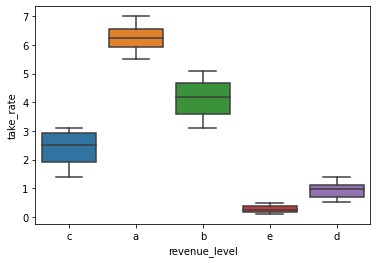

In [32]:
import seaborn as sns
sns.boxplot(category_take_rates["revenue_level"], category_take_rates["take_rate"])
plt.show()

Revenue levels can be categorized by its take rate

In [33]:
category_take_rates.groupby(["categories", "revenue_level"]).size().agg(
  {'count': lambda x: x, 'percent':lambda x: x / x.groupby(level=0).sum() * 100}
  ).unstack(level=0).reset_index()

,categories,revenue_level,count,percent
0,"antique shops - sales, repairs, and restoratio...",a,14165.0,16.546737
1,"antique shops - sales, repairs, and restoratio...",b,35881.0,41.914118
2,"antique shops - sales, repairs, and restoratio...",c,31970.0,37.345513
3,"antique shops - sales, repairs, and restoratio...",d,3080.0,3.597879
4,"antique shops - sales, repairs, and restoratio...",e,510.0,0.595753
5,art dealers and galleries,a,2819.0,27.558901
6,art dealers and galleries,b,5540.0,54.159742
7,art dealers and galleries,c,1608.0,15.720012
8,art dealers and galleries,d,27.0,0.263955
9,art dealers and galleries,e,235.0,2.297390


We can see which categories provide the better amount in revenue for our BNPL company

In [34]:
category_prices = df_trx_sa2.select(["categories", "dollar_value"]).toPandas()
category_prices = category_prices[category_prices["dollar_value"] >= 35]

In [35]:
category_prices.groupby("categories").agg(["mean", "std", "median", "count"])

dollar_value               \
                                                           mean          std   
categories                                                                     
antique shops - sales, repairs, and restoration...   412.777321  2089.413145   
art dealers and galleries                           2095.124768  2261.841612   
artist supply and craft shops                        403.965943   410.236982   
bicycle shops - sales and service                    369.754576   570.686431   
books, periodicals, and newspapers                   282.206695   235.657936   
cable, satellite, and other pay television and ...   101.408574    55.766953   
computer programming , data processing, and int...   214.516641   158.912953   
computers, computer peripheral equipment, and s...   238.913885   256.398853   
digital goods: books, movies, music                   89.982122    48.374061   
equipment, tool, furniture, and appliance rent ...  1552.474967  1734.891243   
florists supplies, nursery stock, and flowers        180.821069   189.657448   
furniture, home furnishings and equipment shops...   255.667868   477.136400   
gift, card, novelty, and souvenir shops               92.969999    49.756544   
health and beauty spas                               334.439518   283.048662   
hobby, toy and game shops                            326.283435   597.381199   
jewelry, watch, clock, and silverware shops         9314.724158  7610.737140   
lawn and garden supply outlets, including nurse...   339.376720   466.353024   
motor vehicle supplies and new parts                 381.132205   664.753409   
music shops - musical instruments, pianos, and ...   334.774261   414.773756   
opticians, optical goods, and eyeglasses             149.361499   157.229241   
shoe shops                                           232.942513   208.971962   
stationery, office supplies and printing and wr...   481.086309   372.755802   
telecom                                             1876.880437  1870.936950   
tent and awning shops                                204.926008   436.659852   
watch, clock, and jewelry repair shops               107.989546    73.350239   

                                                                         
                                                         median   count  
categories                                                               
antique shops - sales, repairs, and restoration...   147.006323   73844  
art dealers and galleries                           1566.347822   10097  
artist supply and craft shops                        267.499083  140402  
bicycle shops - sales and service                    137.101317   90635  
books, periodicals, and newspapers                   212.869792  167085  
cable, satellite, and other pay television and ...    87.040906  334057  
computer programming , data processing, and int...   177.191737  219187  
computers, computer peripheral equipment, and s...   120.188424  232392  
digital goods: books, movies, music                   77.517030  398162  
equipment, tool, furniture, and appliance rent ...   984.270815   14589  
florists supplies, nursery stock, and flowers         93.657625  253501  
furniture, home furnishings and equipment shops...   155.247814  207794  
gift, card, novelty, and souvenir shops               81.126657  526814  
health and beauty spas                               250.706441  104488  
hobby, toy and game shops                            113.360322   89063  
jewelry, watch, clock, and silverware shops         7590.698411    2353  
lawn and garden supply outlets, including nurse...   213.166067  153114  
motor vehicle supplies and new parts                 249.673044  138753  
music shops - musical instruments, pianos, and ...   132.751814  120938  
opticians, optical goods, and eyeglasses              87.609265  220480  
shoe shops                                           160.985658  175534  
stationery, office supplies and pr

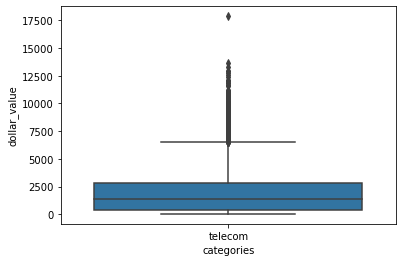

In [36]:
sns.boxplot(category_prices[category_prices["categories"] == "telecom"].loc[:,"categories"], \
    category_prices[category_prices["categories"] == "telecom"].loc[:,"dollar_value"])
plt.show()

1. Number of unique merchants/consumers per tag - Andrew
2. Age distribution by tag (add visualization) - Andrew
3. Consumer income distribution by tag (add visualization) - Andrew
4. Take rate * Dollar_Value - Andrew

1. Number of Unique Merchants and Consumer per Tag

In [38]:
df_trx_sa2.groupby("categories").agg(countDistinct("merchant_abn"), countDistinct("consumer_id"))

categories,count(merchant_abn),count(consumer_id)
"opticians, optica...",151,20066
"watch, clock, and...",170,20066
computer programm...,191,20066
digital goods: bo...,195,20066
"books, periodical...",164,20066
florists supplies...,180,20066
art dealers and g...,112,8014
antique shops - s...,120,19799
"gift, card, novel...",182,20066
"equipment, tool, ...",134,11721


Calculating Revenue (Take Rate / 100 * Dollar Value) and taking the top 10 highest revenues

In [39]:
@F.udf(FloatType())
def get_revenue(take_rate, dollar_value):
    return (take_rate / 100) * dollar_value + 0.3

In [40]:
trx_over35 = df_trx_sa2.where(F.col("dollar_value") >= 35)
trx_over35 = trx_over35.withColumn("revenue", get_revenue(F.col("take_rate"), F.col("dollar_value")))

In [41]:
revenue_per_tag = trx_over35.groupby("categories").sum("revenue").sort("sum(revenue)", ascending=False)

In [42]:
revenue_per_tag.show(10, vertical=True)

-RECORD 0----------------------------
 categories   | tent and awning s... 
 sum(revenue) | 2979765.055367738    
-RECORD 1----------------------------
 categories   | artist supply and... 
 sum(revenue) | 2569463.382230222    
-RECORD 2----------------------------
 categories   | gift, card, novel... 
 sum(revenue) | 2534133.2285147607   
-RECORD 3----------------------------
 categories   | computers, comput... 
 sum(revenue) | 2482338.872164458    
-RECORD 4----------------------------
 categories   | motor vehicle sup... 
 sum(revenue) | 2480661.0497367084   
-RECORD 5----------------------------
 categories   | furniture, home f... 
 sum(revenue) | 2471770.1500543654   
-RECORD 6----------------------------
 categories   | computer programm... 
 sum(revenue) | 2188263.999994606    
-RECORD 7----------------------------
 categories   | lawn and garden s... 
 sum(revenue) | 2149174.160207212    
-RECORD 8----------------------------
 categories   | florists supplies... 
 sum(revenue

In [43]:
top10_tags = revenue_per_tag.select("categories").head(10)
for i in range(len(top10_tags)):
    top10_tags[i] = top10_tags[i].__getitem__('categories')

top10_tags

['tent and awning shops',
 'artist supply and craft shops',
 'gift, card, novelty, and souvenir shops',
 'computers, computer peripheral equipment, and software',
 'motor vehicle supplies and new parts',
 'furniture, home furnishings and equipment shops, and manufacturers, except appliances',
 'computer programming , data processing, and integrated systems design services',
 'lawn and garden supply outlets, including nurseries',
 'florists supplies, nursery stock, and flowers',
 'books, periodicals, and newspapers']

2. Age distribution by tag

In [44]:
pd_age_tag = df_trx_sa2.select("sa2_maincode_2016", "categories").toPandas()

In [45]:
pd_age_tag["sa2_maincode_2016"] = pd_age_tag["sa2_maincode_2016"].astype("float64")

In [46]:
age_cols = ["sa2_main16", "persons_age_20_24", "persons_age_25_29" , "persons_age_30_34", "persons_age_35_39", "persons_age_40_44", \
    "persons_age_45_49", "persons_age_50_54", "persons_age_55_59", "persons_age_60_64", "persons_age_65_69", "persons_age_70_74", \
        "persons_age_75_79", "persons_age_80_84", "persons_age_85_plus"]

pd_age_tag = pd_age_tag.merge(age[age_cols], left_on="sa2_maincode_2016", right_on="sa2_main16", how="inner")

In [47]:
pd_age_tag_final = pd_age_tag.groupby(["categories", "sa2_main16"]).mean().groupby("categories").sum()

In [48]:
pd_age_tag_final["Total"] = pd_age_tag_final.sum(axis=1)

In [49]:
for column in age_cols[1:]:
    pd_age_tag_final[column] = pd_age_tag_final[column] / pd_age_tag_final["Total"] * 100

In [50]:
pd_age_tag_final.head()

,sa2_maincode_2016,persons_age_20_24,persons_age_25_29,persons_age_30_34,persons_age_35_39,persons_age_40_44,persons_age_45_49,persons_age_50_54,persons_age_55_59,persons_age_60_64,persons_age_65_69,persons_age_70_74,persons_age_75_79,persons_age_80_84,persons_age_85_plus,Total
categories,,,,,,,,,,,,,,,,
"antique shops - sales, repairs, and restoration services",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
art dealers and galleries,3.592152e+11,0.000254,0.000306,0.000332,0.000327,0.000305,0.000273,0.000288,0.000266,0.000243,0.000214,0.000185,0.000128,0.000088,0.000091,3.592271e+11
artist supply and craft shops,3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
bicycle shops - sales and service,3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"books, periodicals, and newspapers",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11


In [51]:
pd_age_tag_final = pd_age_tag_final.query("categories in @top10_tags")

In [52]:
pd_age_tag_final.head(10)
# Values displayed is the percentage of people in that age bracket

,sa2_maincode_2016,persons_age_20_24,persons_age_25_29,persons_age_30_34,persons_age_35_39,persons_age_40_44,persons_age_45_49,persons_age_50_54,persons_age_55_59,persons_age_60_64,persons_age_65_69,persons_age_70_74,persons_age_75_79,persons_age_80_84,persons_age_85_plus,Total
categories,,,,,,,,,,,,,,,,
artist supply and craft shops,3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"books, periodicals, and newspapers",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"computer programming , data processing, and integrated systems design services",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"computers, computer peripheral equipment, and software",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"florists supplies, nursery stock, and flowers",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"furniture, home furnishings and equipment shops, and manufacturers, except appliances",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"gift, card, novelty, and souvenir shops",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
"lawn and garden supply outlets, including nurseries",3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11
motor vehicle supplies and new parts,3.705616e+11,0.000255,0.000308,0.000333,0.000328,0.000306,0.000274,0.000289,0.000267,0.000243,0.000215,0.000185,0.000128,0.000088,0.000091,3.705738e+11


3. Consumer income distribution by tag

In [53]:
income_cols = ["sa2_code", "median_aud"]
pd_income_tag = pd_age_tag.merge(income[income_cols], left_on="sa2_maincode_2016", right_on="sa2_code")

In [54]:
pd_income_tag_final = pd_income_tag.groupby(["categories", "sa2_main16"]).mean().groupby("categories").agg({'median_aud': 'mean'})

In [55]:
pd_income_tag_final

,median_aud
categories,
"antique shops - sales, repairs, and restoration services",49423.353442
art dealers and galleries,49363.703437
artist supply and craft shops,49423.353442
bicycle shops - sales and service,49423.353442
"books, periodicals, and newspapers",49423.353442
"cable, satellite, and other pay television and radio services",49423.353442
"computer programming , data processing, and integrated systems design services",49423.353442
"computers, computer peripheral equipment, and software",49423.353442
"digital goods: books, movies, music",49423.353442


In [56]:
pd_income_tag_final = pd_income_tag_final.query("categories in @top10_tags")

In [57]:
pd_income_tag_final

,median_aud
categories,
artist supply and craft shops,49423.353442
"books, periodicals, and newspapers",49423.353442
"computer programming , data processing, and integrated systems design services",49423.353442
"computers, computer peripheral equipment, and software",49423.353442
"florists supplies, nursery stock, and flowers",49423.353442
"furniture, home furnishings and equipment shops, and manufacturers, except appliances",49423.353442
"gift, card, novelty, and souvenir shops",49423.353442
"lawn and garden supply outlets, including nurseries",49423.353442
motor vehicle supplies and new parts,49423.353442


Median income for each tag is very similar

---
### 5. Unique SA2 per merchant


In [58]:
# translate postcodes in transaction to sa2 codes
sa2_cols = ['poa_name_2016', 'sa2_maincode_2016', 'sa2_name_2016', 'geometry']
df_trx_sa2 = (df_trx \
                .join(poa_to_sa2[sa2_cols], 
                     on=[df_trx['postcode'] == poa_to_sa2['poa_name_2016']],
                     how='inner')
                .drop('poa_name_2016')
             )

In [59]:
df_nunique_sa2 = (df_trx_sa2.groupby('merchant_abn')
                   .agg(countDistinct('sa2_maincode_2016')).toPandas())

In [60]:
df_nunique_sa2.head()

,merchant_abn,count(sa2_maincode_2016)
0,73256306726,940
1,83412691377,1222
2,73841664453,353
3,35344855546,487
4,15613631617,556


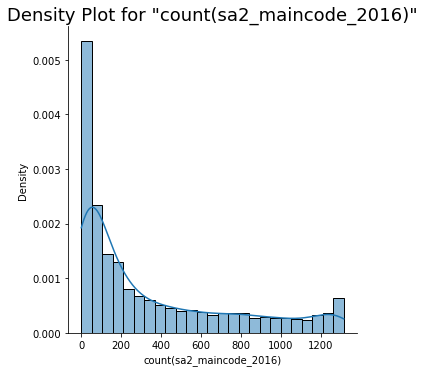

In [61]:
sns.displot(df_nunique_sa2["count(sa2_maincode_2016)"], 
            stat="density", kde=True, bins=25)
plt.title(f'Density Plot for "count(sa2_maincode_2016)"', fontsize=18)
plt.xlabel(f'count(sa2_maincode_2016)')
plt.show()

---
### 5. Unique consumer per merchant


In [62]:
df_nunique_con = (df_trx_sa2.groupby('merchant_abn')
                   .agg(countDistinct('consumer_id')).toPandas())

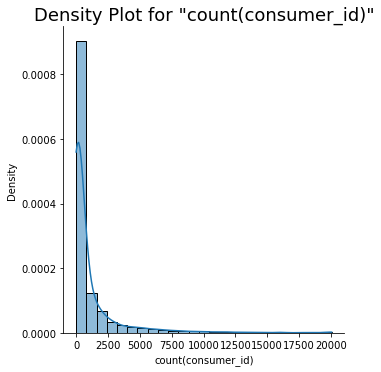

In [63]:
sns.displot(df_nunique_con["count(consumer_id)"], 
            stat="density", kde=True, bins=25)
plt.title(f'Density Plot for "count(consumer_id)"', fontsize=18)
plt.xlabel(f'count(consumer_id)')
plt.show()

---
### 6. Analyze buying power (transaction frequency and monetary value) of SA2, possibly ranking weights to merchants by SA2

In [64]:
sa2_trx = (df_trx_sa2.groupby(['sa2_maincode_2016'])
             .agg({'order_id':'count', 'dollar_value':'sum'})
             .sort(['sa2_maincode_2016']))
unique_cons = (df_trx_sa2.groupby(['sa2_maincode_2016'])
               .agg(countDistinct('consumer_id'))
               .sort(['sa2_maincode_2016']))
unique_merc = (df_trx_sa2.groupby(['sa2_maincode_2016'])
               .agg(countDistinct('merchant_abn'))
               .sort(['sa2_maincode_2016']))

def join_agg(sdf1, sdf2):
    '''
        take two dataframes and join the two dataframes
    '''
    sdf1 = (sdf1.alias("a") \
               .join(sdf2, 
                     on=['sa2_maincode_2016'], 
                     how='inner')
           )
    return sdf1
df_buy_pow = join_agg(sa2_trx, unique_cons)
df_buy_pow = join_agg(df_buy_pow, unique_merc)
    
# renaming a few columns
field_name_change = {"sum(dollar_value)": "total_dollar_value", 
                     "count(order_id)": "transaction_freq",
                     "count(consumer_id)": "n_unique_consumer",
                     "count(merchant_abn)": "n_unique_merchant"}
for old, new in field_name_change.items():
    df_buy_pow = df_buy_pow.withColumnRenamed(old, new)

cols = ['sa2_maincode_2016', 'n_unique_consumer', 
        'transaction_freq', 'total_dollar_value', 'n_unique_merchant']
df_buy_pow = df_buy_pow[cols].sort(['sa2_maincode_2016'])

df_buy_pow = (df_buy_pow.
             withColumn('spending_per_customer', 
                        col("total_dollar_value") / col("n_unique_consumer")))

df_buy_pow = (df_buy_pow.
             withColumn('num_trx_per_customer', 
                        col("transaction_freq") / col("n_unique_consumer")))

df_buy_pow = (df_buy_pow.
             withColumn('sales_per_merchant', 
                        col("total_dollar_value") / col("n_unique_merchant")))

df_buy_pow = (df_buy_pow.
             withColumn('num_trx_per_merchant', 
                        col("transaction_freq") / col("n_unique_merchant")))

In [65]:
df_buy_pow.show(1, vertical=True)

-RECORD 0-----------------------------------
 sa2_maincode_2016     | 101021007.0        
 n_unique_consumer     | 9                  
 transaction_freq      | 2924               
 total_dollar_value    | 453726.3662912975  
 n_unique_merchant     | 914                
 spending_per_customer | 50414.04069903305  
 num_trx_per_customer  | 324.8888888888889  
 sales_per_merchant    | 496.41834386356396 
 num_trx_per_merchant  | 3.199124726477024  
only showing top 1 row



Distribution for n_unique_consumer


Minimum n_unique_consumer by SA2: 1
Median n_unique_consumer by SA2: 10.0
Maximum n_unique_consumer by SA2: 152


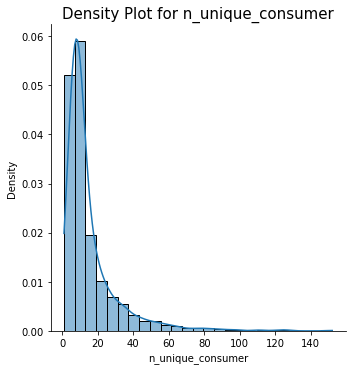

---------------------------------------------------------------------------
Distribution for transaction_freq


Minimum transaction_freq by SA2: 294
Median transaction_freq by SA2: 3189.0
Maximum transaction_freq by SA2: 49643


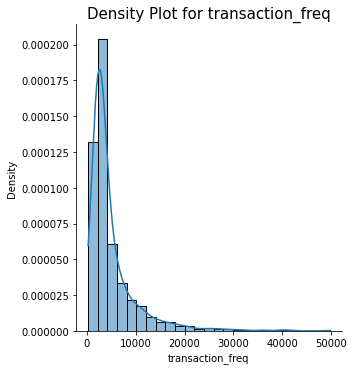

---------------------------------------------------------------------------
Distribution for total_dollar_value


Minimum total_dollar_value by SA2: 40952.08141779106
Median total_dollar_value by SA2: 493890.4444876573
Maximum total_dollar_value by SA2: 7975319.401259059


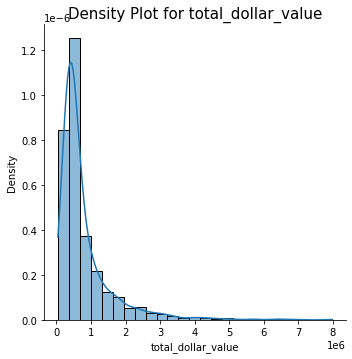

---------------------------------------------------------------------------
Distribution for n_unique_merchant


Minimum n_unique_merchant by SA2: 205
Median n_unique_merchant by SA2: 973.0
Maximum n_unique_merchant by SA2: 2613


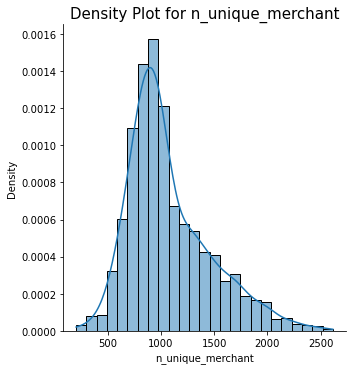

---------------------------------------------------------------------------
Distribution for spending_per_customer


Minimum spending_per_customer by SA2: 40952.08141779106
Median spending_per_customer by SA2: 51272.491660421096
Maximum spending_per_customer by SA2: 64688.66983317636


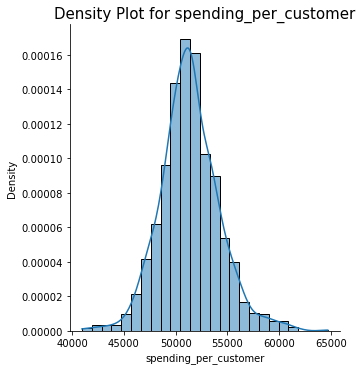

---------------------------------------------------------------------------
Distribution for num_trx_per_customer


Minimum num_trx_per_customer by SA2: 294.0
Median num_trx_per_customer by SA2: 324.671568627451
Maximum num_trx_per_customer by SA2: 353.0


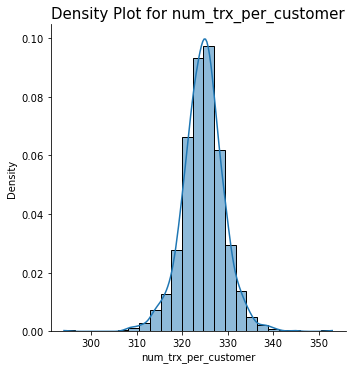

---------------------------------------------------------------------------
Distribution for sales_per_merchant


Minimum sales_per_merchant by SA2: 199.76625081849298
Median sales_per_merchant by SA2: 509.91577324413583
Maximum sales_per_merchant by SA2: 3052.169690493325


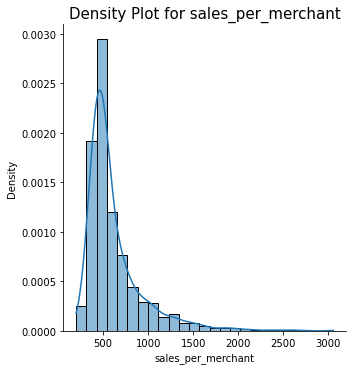

---------------------------------------------------------------------------
Distribution for num_trx_per_merchant


Minimum num_trx_per_merchant by SA2: 1.4266666666666667
Median num_trx_per_merchant by SA2: 3.209843725155235
Maximum num_trx_per_merchant by SA2: 18.998469192499044


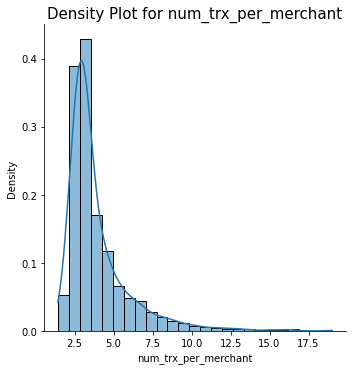

---------------------------------------------------------------------------


In [66]:
fields = ['n_unique_consumer', 'transaction_freq', 'total_dollar_value',
          'n_unique_merchant', 'spending_per_customer', 'num_trx_per_customer',
          'sales_per_merchant', 'num_trx_per_merchant']

for field in fields:
    print(f'Distribution for {field}')
    df_field = df_buy_pow[[field]].toPandas()

    print(f'Minimum {field} by SA2: {df_field.min()[0]}')
    print(f'Median {field} by SA2: {df_field.median()[0]}')
    print(f'Maximum {field} by SA2: {df_field.max()[0]}')

    sns.displot(df_field[field], 
                stat="density", kde=True, bins=25)
    plt.title(f'Density Plot for {field}', fontsize=15)
    plt.xlabel(f'{field}')
    plt.show()
    
    print('---' * 25)

In [67]:
# Rank SA2 with the highest buying power (spending per customer)
df_buy_pow.sort('spending_per_customer', ascending=False).limit(10)

sa2_maincode_2016,n_unique_consumer,transaction_freq,total_dollar_value,n_unique_merchant,spending_per_customer,num_trx_per_customer,sales_per_merchant,num_trx_per_merchant
401051019.0,8,2578,517509.3586654109,901,64688.66983317636,322.25,574.3722071758167,2.86126526082131
407021158.0,6,1935,370895.9301295354,745,61815.98835492256,322.5,497.84688607991325,2.597315436241611
121031408.0,7,2318,432676.09265448886,848,61810.8703792127,331.14285714285717,510.23124133784063,2.733490566037736
212021297.0,5,1625,305129.90819958545,704,61025.98163991709,325.0,433.4231650562293,2.3082386363636362
123021440.0,7,2273,425276.60216874303,863,60753.800309820435,324.7142857142857,492.78864677722254,2.6338354577056777
125011586.0,10,3295,607365.0102319636,1006,60736.50102319636,329.5,603.7425549025482,3.275347912524851
112011237.0,9,2944,546351.1778801798,948,60705.68643113109,327.1111111111111,576.3198078904851,3.1054852320675104
119041382.0,6,1932,363710.2830667319,791,60618.38051112198,322.0,459.8107244838583,2.4424778761061945
201011005.0,4,1279,241371.06660849572,591,60342.76665212393,319.75,408.4112802174208,2.1641285956006766
111031228.0,4,1300,240680.84772803984,626,60170.21193200996,325.0,384.47419764862593,2.07667731629393


In [68]:
# Rank SA2 with the highest transaction frequency (num_trx_per_customer)
df_buy_pow.sort('num_trx_per_customer', ascending=False).limit(10)

sa2_maincode_2016,n_unique_consumer,transaction_freq,total_dollar_value,n_unique_merchant,spending_per_customer,num_trx_per_customer,sales_per_merchant,num_trx_per_merchant
309031239.0,2,706,114982.77883716644,384,57491.38941858322,353.0,299.43431988845424,1.8385416666666667
801091106.0,3,1034,168391.48344223428,507,56130.49448074476,344.6666666666667,332.13310343635953,2.0394477317554243
507051187.0,4,1365,207767.6020278964,584,51941.9005069741,341.25,355.76644182858973,2.337328767123288
801051124.0,7,2381,409495.86888433853,861,58499.40984061979,340.14285714285717,475.6049580538194,2.7653890824622533
301031021.0,4,1358,199311.82814170106,608,49827.957035425265,339.5,327.8155068120083,2.2335526315789473
313021367.0,5,1696,294619.5363851127,705,58923.90727702253,339.2,417.9000516100889,2.405673758865248
210051250.0,5,1694,270330.1499038856,700,54066.02998077712,338.8,386.18592843412233,2.42
209021205.0,3,1015,159980.48863622954,456,53326.82954540985,338.3333333333333,350.83440490401216,2.2258771929824563
601031015.0,4,1353,200468.50700399553,612,50117.12675099888,338.25,327.5629199411692,2.2107843137254903
303011048.0,9,3041,491988.9279296253,947,54665.43643662504,337.8888888888889,519.523683135824,3.211193241816262


In [69]:
# check if the table above by taking one SA2 code
(df_trx_sa2.filter(F.col('sa2_maincode_2016') == 309031239.0)
 .groupby('consumer_id').agg({
                               'order_id':'count',
                               'dollar_value': 'sum' 
                            }))

consumer_id,sum(dollar_value),count(order_id)
41960,50475.727704169294,363
332215,64507.051132997134,343


In [70]:
age.head()

,gml_id,sa2_main16,state_code,state_name,gccsa_code16,gccsa_name16,sa4_code16,sa4_name16,sa3_code16,sa3_name16,...,persons_age_55_59,persons_age_5_9,persons_age_60_64,persons_age_65_69,persons_age_70_74,persons_age_75_79,persons_age_80_84,persons_age_85_plus,persons_total,geometry
0,abs_regional_population_age_sex_sa2_2019.10102...,101021007,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,...,318,381,404,333,288,194,89,75,4222,"MULTIPOLYGON (((149.58420 -35.44430, 149.58440..."
1,abs_regional_population_age_sex_sa2_2019.10102...,101021008,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,...,570,544,508,410,332,249,136,105,8372,"MULTIPOLYGON (((149.21900 -35.36740, 149.21800..."
2,abs_regional_population_age_sex_sa2_2019.10103...,101031015,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10103,Snowy Mountains,...,276,289,283,292,220,176,91,66,3382,"MULTIPOLYGON (((148.60440 -36.13520, 148.60450..."
3,abs_regional_population_age_sex_sa2_2019.10103...,101031016,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10103,Snowy Mountains,...,503,528,468,368,265,167,90,72,7215,"MULTIPOLYGON (((148.27030 -36.46410, 148.27060..."
4,abs_regional_population_age_sex_sa2_2019.10104...,101041017,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10104,South Coast,...,422,545,677,700,662,480,264,310,8025,"MULTIPOLYGON (((150.23540 -35.70390, 150.23530..."


In [71]:
# calculate population of age above 20
left_age = 25
right_age = 29
age['males_above_20'] = age['males_age_20_24']
age['females_above_20'] = age['females_age_20_24']
age['persons_above_20'] = age['persons_age_20_24']

while right_age < 89:
    if right_age == 89:
        right_age = 'plus'

    age['males_above_20'] += age[f'males_age_{left_age}_{right_age}']
    age['females_above_20'] += age[f'females_age_{left_age}_{right_age}']
    age['persons_above_20'] += age[f'persons_age_{left_age}_{right_age}']
    
    left_age += 5
    right_age += 5

In [72]:
pdf_buy_pow = df_buy_pow.toPandas()

In [73]:
# merge df_trx_sa2 with income, age, and population
income['sa2_code'] = income['sa2_code'].astype('float').astype('str')
income_col = ['sa2_code', 'median_aud', 'earners_persons', 
              'median_age_of_earners_years']
pdf_buy_pow = pdf_buy_pow.merge(income[income_col],
                                left_on='sa2_maincode_2016',
                                right_on='sa2_code', how='left')

age['sa2_main16'] = age['sa2_main16'].astype('float').astype('str')
age_col = ['sa2_main16', 'males_above_20', 
           'females_above_20', 'persons_above_20']
pdf_buy_pow = pdf_buy_pow.merge(age[age_col],
                                left_on='sa2_maincode_2016',
                                right_on='sa2_main16', how='left')

In [74]:
pdf_buy_pow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 0 to 1313
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sa2_maincode_2016            1314 non-null   object 
 1   n_unique_consumer            1314 non-null   int64  
 2   transaction_freq             1314 non-null   int64  
 3   total_dollar_value           1314 non-null   float64
 4   n_unique_merchant            1314 non-null   int64  
 5   spending_per_customer        1314 non-null   float64
 6   num_trx_per_customer         1314 non-null   float64
 7   sales_per_merchant           1314 non-null   float64
 8   num_trx_per_merchant         1314 non-null   float64
 9   sa2_code                     1307 non-null   object 
 10  median_aud                   1293 non-null   float64
 11  earners_persons              1293 non-null   float64
 12  median_age_of_earners_years  1293 non-null   float64
 13  sa2_main16        

---
### SA2 (Income, Age and Buying Power) Geospatial Visualization

This section aims to dentify and visualise trends between Income, Age, and Buying Power with SA2. These visualisations and exploratory analysis are meant to help us understand if SA2 areas signifies the distribution of the aforementioned three features.

In [76]:
poa_to_sa2_pd = pd.read_csv("../data/curated/poa_w_sa2.csv")
poa_to_sa2_pd = poa_to_sa2_pd.dropna()

In [77]:
from shapely import wkt

poa_to_sa2_pd['geometry'] = poa_to_sa2_pd['geometry'].astype('str').apply(wkt.loads)
gdf = gpd.GeoDataFrame(poa_to_sa2_pd, crs='epsg:4326')

In [78]:
gdf['geometry'] = gdf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [79]:
# create a JSON 
geoJSON = gdf[['sa2_maincode_2016', 'geometry']].drop_duplicates('sa2_maincode_2016').to_json()

#### 1. Income by SA2 Geospatial Visualization

In [ ]:
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
custom_scale = (pd_income_tag['median_aud'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=pd_income_tag, 
    columns = ['sa2_maincode_2016', 'median_aud'], 
    key_on = 'properties.sa2_maincode_2016', 
    threshold_scale=custom_scale, 
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='Income by SA2 Area'))
m

#### 2. Age by SA2 Geospatial Visualization
This subsection aims to visualize Afterpay's target age group of 18 - 35 years old, accounting for 55.9% of users.

_Source: https://www.nra.net.au/your-guide-to-buy-now-pay-later-platforms-what-your-customers-expect/_

In [87]:
pd_age_tag['persons_age_20_35'] = (pd_age_tag['persons_age_20_24'] + 
                                   pd_age_tag['persons_age_25_29'] + 
                                   pd_age_tag['persons_age_30_34'])

In [ ]:
# Age 20-34
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
custom_scale = (pd_age_tag['persons_age_20_35'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=pd_age_tag, 
    columns = ['sa2_maincode_2016', 'persons_age_20_35'], 
    key_on = 'properties.sa2_maincode_2016', 
    threshold_scale=custom_scale,
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='Age 20-34 by SA2 Area'))
m

#### 3. Buying Power by SA2 Geospatial Visualization
a. Number of Transaction per Customer

In [ ]:
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=pdf_buy_pow, 
    columns = ['sa2_maincode_2016', 'num_trx_per_customer'], 
    key_on = 'properties.sa2_maincode_2016', 
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='Buying Power (Number of Transactions per Customer) by SA2'))
m

b. Spending per Customer

In [ ]:
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=pdf_buy_pow, 
    columns = ['sa2_maincode_2016', 'spending_per_customer'], 
    key_on = 'properties.sa2_maincode_2016', 
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='Income by SA2 Area'))
m

c. Revenue by Merchant SA2

In [127]:
df_trx_sa2 = spark.read.parquet('../data/curated/df_trx_sa2.parquet')

In [128]:
## take the most frequent consumer SA2 to be merchant SA2
df_sa2_count = (df_trx_sa2.groupby(['merchant_abn', 'sa2_maincode_2016'])
                .agg(F.count("sa2_maincode_2016").alias("count")))
w = Window().partitionBy("merchant_abn").orderBy(F.desc("count"))
df_with_rank = (df_sa2_count.withColumn("rank", F.dense_rank().over(w)))

# get first row sa2 if ties exist
df_merchant_sa2 = (df_with_rank.where(F.col("rank") == 1)
                   .dropDuplicates(subset = ['merchant_abn'])
                   .drop('Rank')
                   .drop('count')
                   .withColumnRenamed('sa2_maincode_2016', 'merchant_sa2'))

# join merchant sa2 to trx data
df_trx_sa2 = (df_trx_sa2 \
                 .join(df_merchant_sa2, 
                       on=['merchant_abn'], 
                       how='left')
             )

In [129]:
df_revenue = df_trx_sa2.groupby('sa2_maincode_2016').sum('revenue').toPandas()

In [144]:
df_revenue['sa2_maincode_2016'] = df_revenue['sa2_maincode_2016'].astype(float)

In [ ]:
# BNPL Revenue by SA2 Area
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=df_revenue, 
    columns = ['sa2_maincode_2016', 'sum(revenue)'], 
    key_on = 'properties.sa2_maincode_2016', 
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='BNPL Revenue by SA2 Area'))
m

In [142]:
df_abn = df_trx_sa2.groupby('sa2_maincode_2016').agg(countDistinct('merchant_abn')).toPandas()

In [145]:
df_abn['sa2_maincode_2016'] = df_abn['sa2_maincode_2016'].astype(float)

In [ ]:
# Number of Merchant by SA2 Area
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=df_abn, 
    columns = ['sa2_maincode_2016', 'count(merchant_abn)'], 
    key_on = 'properties.sa2_maincode_2016', 
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='Merchant in SA2'))
m

In [149]:
df_trx_sa2.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- revenue: float (nullable = true)
 |-- merchant_sa2: string (nullable = true)



In [151]:
df_tent = (df_trx_sa2.filter(F.col('categories')=='tent and awning shops')
           .groupby('sa2_maincode_2016').agg(countDistinct('merchant_abn'))).toPandas()

In [154]:
df_tent['sa2_maincode_2016'] = df_tent['sa2_maincode_2016'].astype(float)

In [ ]:
# Number of Tent and Awning Merchant by SA2 Area
m = folium.Map(location=[-38.043995, 145.264296], tiles="Stamen Terrain", zoom_start=8)
m.add_child(folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    data=df_tent, 
    columns = ['sa2_maincode_2016', 'count(merchant_abn)'], 
    key_on = 'properties.sa2_maincode_2016', 
    fill_color='YlGnBu', 
    name='choropleth', 
    legend_name='Tent and Awning Merchant in SA2'))
m